### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [3]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Resolution_category'])


In [4]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

In [5]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [6]:
data = data.groupby('Resolution_category').filter(lambda x : len(x)>2000)

In [7]:
data.Resolution_category.value_counts()

Data Issue                                 15233
Job Failure                                14386
User Access / Permission                    5499
User knowledge or training error            4559
Incident Opened in Error / Not serviced     3908
Configuration Error                         3070
Connectivity                                2726
Name: Resolution_category, dtype: int64

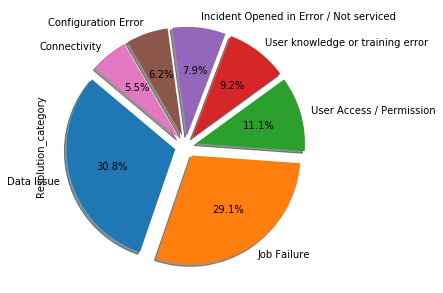

In [8]:
chart=data.Resolution_category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolution_category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [9]:
from sklearn.utils import resample

df_1 = data[data.Resolution_category=='Data Issue']
df_2 = data[data.Resolution_category=='Job Failure']
df_3 = data[data.Resolution_category=='User Access / Permission']
df_4 = data[data.Resolution_category=='User knowledge or training error']
df_5 = data[data.Resolution_category=='Incident Opened in Error / Not serviced']
df_6 = data[data.Resolution_category=='Configuration Error']
df_7 = data[data.Resolution_category=='Connectivity']


df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled])

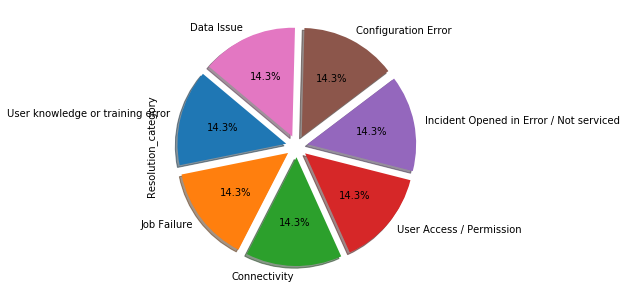

In [10]:
chart=data.Resolution_category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolution_category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [11]:
data.Resolution_category.value_counts()

User knowledge or training error           2726
Job Failure                                2726
Connectivity                               2726
User Access / Permission                   2726
Incident Opened in Error / Not serviced    2726
Configuration Error                        2726
Data Issue                                 2726
Name: Resolution_category, dtype: int64

In [12]:
data['target_sol'] = data.Resolution_category.astype('category').cat.codes

In [13]:
labels_sol = data.Resolution_category.astype('category').cat.categories

In [14]:
df = pd.DataFrame(labels_sol) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_sol.csv')

In [15]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sol
9489,INC000019021936,When did this issue begin?:2018-09-11\r\n\r\nW...,Delay in Atlas Stage job for Vision,SHARAT SULAKHE (643021703),Priority 4,Software,Enterprise software,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,ASPAC IN BANGALORE,ITAS ETCS FINANCIAL SERVICES L2,KOKILAPRIYA JUSTIN DIRAVIAM (643020470),KB000010032380,GLOBAL,2018-09-11 9:57,2018-09-11 16:48,2
39890,INC000017640599,•\tProvide the website address (URL) you are t...,Software - J&J business applications: Alert / ...,PATRICIA DANGELO (1057870),Priority 3,Software,Enterprise software,High,Limited,BRAZIL MIND BI - PRD,...,Closed Complete,Data Issue,LA BR SAO PAULO,ITAS-LA POD_2 BI APPS L2,RAUNAK SUBODH PRADHAN (643015282),NaN,LATAM,2017-11-17 8:15,2017-11-22 4:29,2
5087,INC000019806538,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,NaN,CBT RR COG,KOKILAPRIYA JUSTIN DIRAVIAM (643020470),KB000010048673,GLOBAL,2019-02-23 10:25,2019-02-24 15:10,2
42154,INC000019309561,Product job failure at 560 activity code\r\nJo...,Software - J&J business applications: Alert / ...,MRUGANG PURAO (643021133),Priority 3,Application,Job Failure,High,Limited,ONEMD SCG REPORTING & ANALYTICS - PROD,...,Closed Complete,Data Issue,ASPAC IN INDIA,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010042585,NaN,2018-11-08 22:12,2018-11-08 23:43,2
12878,INC000018089215,When did this issue begin?:2018-02-26\r\n\r\nW...,GFS-FP&A-FINANCIAL PLANNING TM1-The exchange r...,SALMA VIRANI (361871),Priority 3,Software,Enterprise software,High,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,Closed Complete,Data Issue,NA US NJ TITUSVILLE,GFS-FP&A COE TM1,PANKAJ SARKAR (152038360),KB000010032380,GLOBAL,2018-02-27 8:48,2018-03-05 5:32,2


In [16]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [17]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [18]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [19]:
word_distribution.head()

,bins,counts
0,0-10,5619
1,10-30,7558
2,30-60,3568
3,60-130,1960
4,>130,377


Text(0.5, 1.0, 'Word distribution per bin')

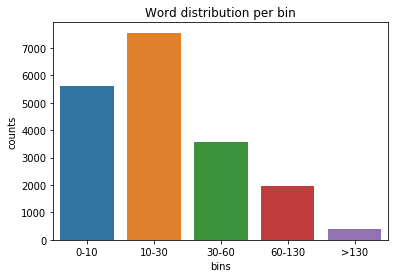

In [20]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [21]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sol,num_words,bins
9489,INC000019021936,When did this issue begin?:2018-09-11\r\n\r\nW...,Delay in Atlas Stage job for Vision,SHARAT SULAKHE (643021703),Priority 4,Software,Enterprise software,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,ASPAC IN BANGALORE,ITAS ETCS FINANCIAL SERVICES L2,KOKILAPRIYA JUSTIN DIRAVIAM (643020470),KB000010032380,GLOBAL,2018-09-11 9:57,2018-09-11 16:48,2,36,30-60
39890,INC000017640599,•\tProvide the website address (URL) you are t...,Software - J&J business applications: Alert / ...,PATRICIA DANGELO (1057870),Priority 3,Software,Enterprise software,High,Limited,BRAZIL MIND BI - PRD,...,LA BR SAO PAULO,ITAS-LA POD_2 BI APPS L2,RAUNAK SUBODH PRADHAN (643015282),NaN,LATAM,2017-11-17 8:15,2017-11-22 4:29,2,40,30-60
5087,INC000019806538,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,GFS - FP&A - FINANCIAL REPORTING,...,NaN,CBT RR COG,KOKILAPRIYA JUSTIN DIRAVIAM (643020470),KB000010048673,GLOBAL,2019-02-23 10:25,2019-02-24 15:10,2,18,10-30
42154,INC000019309561,Product job failure at 560 activity code\r\nJo...,Software - J&J business applications: Alert / ...,MRUGANG PURAO (643021133),Priority 3,Application,Job Failure,High,Limited,ONEMD SCG REPORTING & ANALYTICS - PROD,...,ASPAC IN INDIA,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010042585,NaN,2018-11-08 22:12,2018-11-08 23:43,2,23,10-30
12878,INC000018089215,When did this issue begin?:2018-02-26\r\n\r\nW...,GFS-FP&A-FINANCIAL PLANNING TM1-The exchange r...,SALMA VIRANI (361871),Priority 3,Software,Enterprise software,High,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,NA US NJ TITUSVILLE,GFS-FP&A COE TM1,PANKAJ SARKAR (152038360),KB000010032380,GLOBAL,2018-02-27 8:48,2018-03-05 5:32,2,73,60-130


In [22]:
num_class_sol = len(np.unique(data.Resolution_category.values))
y_sol = data['target_sol'].values


## Topic Modelling

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [24]:
data['Description'] = data['Description'].astype(str)

In [25]:
type(data['Description'])

pandas.core.series.Series

In [26]:
data_description = data.Description.values

In [27]:
type(data_description)

numpy.ndarray

In [28]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

0000 10.16340598478697
00000 10.16340598478697
000000000520001500 10.16340598478697
000000000520016500 10.16340598478697
000000000520016600 10.16340598478697
000000000520016700 10.16340598478697
0000016327 10.16340598478697
0000018417 10.16340598478697
0000025578 10.16340598478697
000004026815 10.16340598478697
000004026816 10.16340598478697
000004026817 10.16340598478697
000004026818 10.16340598478697
000004026819 10.16340598478697
000004026848 10.16340598478697
000004026849 10.16340598478697
000004026980 10.16340598478697
000004026981 10.16340598478697
000004026982 10.16340598478697
000004026983 10.16340598478697
000004026984 10.16340598478697
000004026985 10.16340598478697
000004026988 10.16340598478697
000004026989 10.16340598478697
000004027406 10.16340598478697
000004027407 10.16340598478697
000004027408 10.16340598478697
000004027409 10.16340598478697
000004027410 10.16340598478697
000004027411 10.16340598478697
000004027412 10.16340598478697
000004027413 10.16340598478697
00000

31263 10.16340598478697
31267 10.16340598478697
31268 10.16340598478697
312928126 10.16340598478697
31293 10.16340598478697
31294 10.16340598478697
31295 10.16340598478697
31298 10.16340598478697
3130 10.16340598478697
31306 10.16340598478697
31329 10.16340598478697
31330 10.16340598478697
31331 10.16340598478697
31332 10.16340598478697
3133spea 10.16340598478697
315624542 10.16340598478697
3162 10.16340598478697
3165 10.16340598478697
31662 10.16340598478697
31673 10.16340598478697
31674 10.16340598478697
31675 10.16340598478697
31676 10.16340598478697
31701 10.16340598478697
3174 10.16340598478697
31778 10.16340598478697
3180 10.16340598478697
318137 10.16340598478697
3182 10.16340598478697
319 10.16340598478697
319742467 10.16340598478697
31am 10.16340598478697
320000 10.16340598478697
3200000 10.16340598478697
320775544 10.16340598478697
321000002 10.16340598478697
32256 10.16340598478697
323 10.16340598478697
32402961 10.16340598478697
326 10.16340598478697
326k 10.16340598478697


7051 10.16340598478697
70553879 10.16340598478697
7056 10.16340598478697
706 10.16340598478697
7060 10.16340598478697
7067 10.16340598478697
707 10.16340598478697
7079 10.16340598478697
7093 10.16340598478697
7094 10.16340598478697
70e2452c 10.16340598478697
7106 10.16340598478697
710k 10.16340598478697
7117 10.16340598478697
713 10.16340598478697
714 10.16340598478697
7160 10.16340598478697
717 10.16340598478697
7196 10.16340598478697
720 10.16340598478697
72011059 10.16340598478697
72054 10.16340598478697
7210917 10.16340598478697
7224 10.16340598478697
7226 10.16340598478697
72285 10.16340598478697
7235mcs 10.16340598478697
7243 10.16340598478697
72495 10.16340598478697
7260 10.16340598478697
7265 10.16340598478697
7290630034 10.16340598478697
7290630049 10.16340598478697
7293 10.16340598478697
7294 10.16340598478697
7305 10.16340598478697
7316776003 10.16340598478697
7320732014 10.16340598478697
7379071003 10.16340598478697
7379071012 10.16340598478697
738 10.16340598478697
7381219

comming 10.16340598478697
commissioned 10.16340598478697
commitjob 10.16340598478697
committedinstantisallocation 10.16340598478697
committing 10.16340598478697
commons 10.16340598478697
commops 10.16340598478697
commt_qty 10.16340598478697
compaiono 10.16340598478697
company_cd 10.16340598478697
company_codeas 10.16340598478697
company_name 10.16340598478697
comparable 10.16340598478697
comparative 10.16340598478697
compares 10.16340598478697
comparisons 10.16340598478697
compatibiliad 10.16340598478697
compatiblity 10.16340598478697
compañía 10.16340598478697
compdtlsdb 10.16340598478697
competent 10.16340598478697
competente 10.16340598478697
competitors 10.16340598478697
compile 10.16340598478697
compileandrespond 10.16340598478697
compileinternal 10.16340598478697
complementary 10.16340598478697
completado 10.16340598478697
completata 10.16340598478697
complete_exwhls_rcv 10.16340598478697
completions 10.16340598478697
compliancecasereceipt 10.16340598478697
compliancewire 10.1634

grab 10.16340598478697
graeme 10.16340598478697
grahl 10.16340598478697
grahm 10.16340598478697
grammar 10.16340598478697
gran 10.16340598478697
grandhi 10.16340598478697
greer 10.16340598478697
greiz 10.16340598478697
grmtm1 10.16340598478697
grocery 10.16340598478697
gropups 10.16340598478697
ground 10.16340598478697
group_name 10.16340598478697
grouped 10.16340598478697
grouping 10.16340598478697
gruber 10.16340598478697
grátis 10.16340598478697
gs_country_input 10.16340598478697
gsdb 10.16340598478697
gsddashboardv2_0 10.16340598478697
gsi 10.16340598478697
gsk 10.16340598478697
gsoncini 10.16340598478697
gspmp32_unx_gnp_l 10.16340598478697
gspmp32_unx_gnp_lnx_tale 10.16340598478697
gspmp32_unx_gnp_lnx_talend_comp 10.16340598478697
gspmp32_unx_gnp_lnx_talend_compass_ 10.16340598478697
gspmq22_unx_gnq_lnx_talend_com 10.16340598478697
gspmq22_unx_gnq_lnx_talend_comp 10.16340598478697
gspmq22_unx_gnq_lnx_talend_compa 10.16340598478697
gspmq22_unx_gnq_lnx_talend_compas 10.1634059847869

mariia 10.16340598478697
mario 10.16340598478697
marjetka 10.16340598478697
marketingintelligence 10.16340598478697
marketingtools 10.16340598478697
marketplace 10.16340598478697
marking 10.16340598478697
markus 10.16340598478697
marlene 10.16340598478697
marques 10.16340598478697
marsisq1 10.16340598478697
marsisq2 10.16340598478697
marta 10.16340598478697
martha 10.16340598478697
martin 10.16340598478697
martina 10.16340598478697
marzia 10.16340598478697
março 10.16340598478697
maría 10.16340598478697
masayuki 10.16340598478697
maschine 10.16340598478697
maser 10.16340598478697
master_data 10.16340598478697
master_data_01_bw_bpc330_emea_text 10.16340598478697
mastercam 10.16340598478697
mastercentrifyzone 10.16340598478697
mastercode 10.16340598478697
mastercustomer_my 10.16340598478697
mastercustomer_sg 10.16340598478697
masterproduct 10.16340598478697
masterproduct_sg 10.16340598478697
mat_plant 10.16340598478697
mat_uom_fw 10.16340598478697
mateescu 10.16340598478697
mateja 10.163

s_m_dpy_jtr_cust_flat_ucn_indv_upd 10.16340598478697
s_m_edw_actual_fact_load 10.16340598478697
s_m_edw_cust_360_load 10.16340598478697
s_m_euss_stg_csar_custom_kit_prod 10.16340598478697
s_m_euss_stg_jnj_exp_prc_rpt 10.16340598478697
s_m_euss_stg_jnj_prc_comp_rpt 10.16340598478697
s_m_gdw_canada_customer_load 10.16340598478697
s_m_janca_ph_biw_stg_ct_del_som_matpricereg_dim 10.16340598478697
s_m_janca_ph_biw_stg_ct_deliver_som_backorder_ins 10.16340598478697
s_m_janca_ph_biw_stg_ct_deliver_som_batchstocks 10.16340598478697
s_m_janca_ph_biw_stg_ct_deliver_som_delitem_gra_ins 10.16340598478697
s_m_janca_ph_biw_stg_ct_deliver_som_salesblng 10.16340598478697
s_m_load_sap_ff_tmp 10.16340598478697
s_m_load_siperian_to_dimn401_cust 10.16340598478697
s_m_load_siperian_to_dimn480_cust 10.16340598478697
s_m_load_siperian_to_dimn480_cust_exceptions 10.16340598478697
s_m_load_siperian_to_fact451_addr 10.16340598478697
s_m_load_siperian_to_fact452_lics 10.16340598478697
s_m_load_siperian_to_fact45

In [29]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [30]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['0000' 'local_cost_amount' 'local_material_long_cd' 'local_mtd_amount'
 'localcode' 'localdatawarehouse' 'locating' 'location_name' 'locvation'
 'log_dataquality']

Features with highest idf:
['badar' 'baddi' 'badsqlgrammarexception' 'bakare' 'bakersfield'
 'balancers' 'balancesheet' 'balancing' 'balnk' 'über']


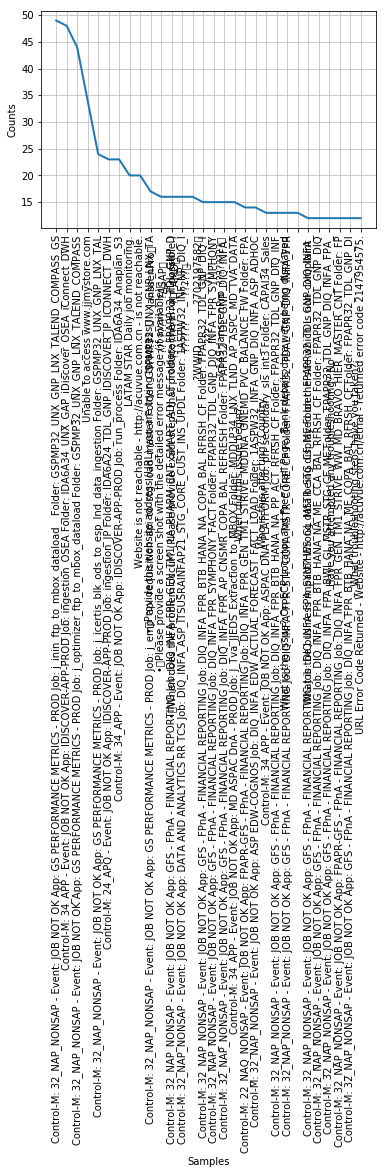

In [31]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [32]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(19082, 26371)
  (0, 25885)	0.09414744055140209
  (0, 10407)	0.09829863244416535
  (0, 24286)	0.1828797424857916
  (0, 15089)	0.17777322077049676
  (0, 7679)	0.09943021312067289
  (0, 1519)	0.1315027188441031
  (0, 440)	0.17532058327116168
  (0, 661)	0.17263928590003014
  (0, 25898)	0.0989649755690991
  (0, 15055)	0.24529022541247408
  (0, 6383)	0.09940893741016346
  (0, 25471)	0.3889516157084912
  (0, 25083)	0.14290354040585104
  (0, 25880)	0.29520586107125324
  (0, 24247)	0.1275648712513449
  (0, 10167)	0.2117671181619654
  (0, 14409)	0.09429514945620676
  (0, 7251)	0.2987948968456077
  (0, 23392)	0.23881390222687354
  (0, 16014)	0.09318361597934233
  (0, 12700)	0.07836962815897286
  (0, 8110)	0.09763404863398067
  (0, 14347)	0.09929214114915495
  (0, 22882)	0.28645690204167934
  (0, 13619)	0.1858842178829189
  :	:
  (19081, 26247)	0.14244081689441082
  (19081, 7275)	0.07602074184638469
  (19081, 6766)	0.07430716155208145
  (19081, 24669)	0.15200892059427717
  (19081, 18629)	0.074981

In [34]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

19082
                                             Description  index
9489   When did this issue begin?:2018-09-11\r\n\r\nW...   9489
39890  •\tProvide the website address (URL) you are t...  39890
5087   Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...   5087
42154  Product job failure at 560 activity code\r\nJo...  42154
12878  When did this issue begin?:2018-02-26\r\n\r\nW...  12878


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [35]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 5].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['This', 'is', 'just', 'a', 'question.\r\nDo', 'Secondary', 'Admin', 'Account', '"Admin_ssekino1",', '"Admin_stanak34"', 'and', '"Admin_hshinoh1"', 'join', 'in', 'the', 'following', 'group', 'of', 'the', 'domain', 'controller?\r\n\r\nJNJ\\ITS-EP-AWSAJUSGP1132-TempWinAdmin\r\nJNJ\\ITS-EP-AWSAJUSGP1152-TempWinAdmin\r\nJNJ\\ITS-EP-AWSAJUSGP1186-TempWinAdmin\r\n\r\nJNJ\\ITS-EP-AWSAJUSGP1132-WinAdmin\r\nJNJ\\ITS-EP-AWSAJUSGP1152-WinAdmin\r\nJNJ\\ITS-EP-AWSAJUSGP1186-WinAdmin\r\n\r\nJNJ\\ITS-EP-AWSAJUSGP1132-RDPUsers\r\nJNJ\\ITS-EP-AWSAJUSGP1152-RDPUsers\r\nJNJ\\ITS-EP-AWSAJUSGP1186-RDPUsers\r\n']


 tokenized and lemmatized document: 
['question', 'secondari', 'admin', 'account', 'admin_ssekino', 'admin_stanak', 'admin_hshinoh', 'join', 'follow', 'group', 'domain', 'control', 'awsajusgp', 'tempwinadmin', 'awsajusgp', 'tempwinadmin', 'awsajusgp', 'tempwinadmin', 'awsajusgp', 'winadmin', 'awsajusgp', 'winadmin', 'awsajusgp', 'winadmin', 'awsajusgp', 'rdpuser', 'awsajusgp',

9489     [issu, begin, affect, vision, user, issu, dela...
39890    [provid, websit, address, tri, access, provid,...
5087     [control, event, fpna, financi, report, folder...
42154    [product, failur, activ, code, fail, load, tab...
12878    [issu, begin, affect, global, vision, issu, gl...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [36]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 affect
1 atla
2 attempt
3 begin
4 busi
5 delay
6 impact
7 issu
8 signific
9 stage
10 step


In [37]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(6, 2),
 (13, 1),
 (17, 1),
 (75, 1),
 (90, 1),
 (111, 1),
 (152, 2),
 (170, 1),
 (176, 2),
 (179, 1),
 (183, 1),
 (464, 1),
 (465, 1)]

In [38]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 6 ("issu") appears 2 time.
Word 13 ("vision") appears 1 time.
Word 17 ("detail") appears 1 time.
Word 75 ("data") appears 1 time.
Word 90 ("group") appears 1 time.
Word 111 ("type") appears 1 time.
Word 152 ("assign") appears 2 time.
Word 170 ("intern") appears 1 time.
Word 176 ("recon") appears 2 time.
Word 179 ("process") appears 1 time.
Word 183 ("weekli") appears 1 time.
Word 464 ("deploy") appears 1 time.
Word 465 ("track") appears 1 time.


In [39]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.11702549265846215),
 (1, 0.11724323681938705),
 (2, 0.11758111273309796),
 (3, 0.11417994410247588),
 (4, 0.2862220217981535),
 (5, 0.11690701311723395),
 (6, 0.1895598196467263),
 (7, 0.4717300445277892),
 (8, 0.37727664439258873),
 (9, 0.11567515038374784),
 (10, 0.11641553418344758),
 (11, 0.23544144428326066),
 (12, 0.12679942377326786),
 (13, 0.5923364526967607)]


### Finding out 5 topics using LDA

In [40]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [41]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.130*"dim_task_id" + 0.119*"task_nam" + 0.100*"end_tim" + 0.100*"start_tim" + 0.072*"dim_slt_id"'), (1, '0.099*"issu" + 0.090*"troubleshoot" + 0.050*"busi" + 0.047*"impact" + 0.046*"step"'), (2, '0.038*"access" + 0.025*"user" + 0.025*"http" + 0.022*"error" + 0.016*"unabl"'), (3, '0.023*"error" + 0.022*"fail" + 0.020*"issu" + 0.020*"data" + 0.018*"provid"'), (4, '0.065*"folder" + 0.061*"event" + 0.061*"control" + 0.039*"report" + 0.039*"prod"')]
Topic: 0 
Words: 0.130*"dim_task_id" + 0.119*"task_nam" + 0.100*"end_tim" + 0.100*"start_tim" + 0.072*"dim_slt_id" + 0.064*"task" + 0.062*"follow" + 0.061*"violat" + 0.061*"constraint" + 0.029*"fact_run_id"
Topic: 1 
Words: 0.099*"issu" + 0.090*"troubleshoot" + 0.050*"busi" + 0.047*"impact" + 0.046*"step" + 0.046*"take" + 0.046*"affect" + 0.046*"attempt" + 0.045*"begin" + 0.016*"user"
Topic: 2 
Words: 0.038*"access" + 0.025*"user" + 0.025*"http" + 0.022*"error" + 0.016*"unabl" + 0.015*"issu" + 0.014*"page" + 0.012*"applic" + 0.011*"code" 

In [42]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [43]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [44]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [45]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(87, 5)
(5, 87)


In [46]:
df_lda

,access,account,affect,applic,assign,attach,attempt,avail,begin,busi,...,ticket,tri,troubleshoot,unabl,user,violat,websit,work,wwid,yxmd
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002052,0.06076,0.000000,0.000000,0.000000,0.007947
1,0.004514,0.000000,0.046072,0.000000,0.000000,0.000000,0.045566,0.000000,0.045205,0.049722,...,0.000000,0.000000,0.090362,0.000000,0.015832,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.038474,0.000000,0.000000,0.012434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005886,0.007277,0.000000,0.016245,0.025314,0.00000,0.009346,0.008142,0.006036,0.000000
3,0.008333,0.008471,0.000000,0.000000,0.000000,0.010569,0.000000,0.007565,0.000000,0.000000,...,0.000000,0.006697,0.000000,0.000000,0.014552,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.016856,0.000000,0.000000,0.000000,0.006965,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016711,0.023932,0.00000,0.000000,0.000000,0.000000,0.000000


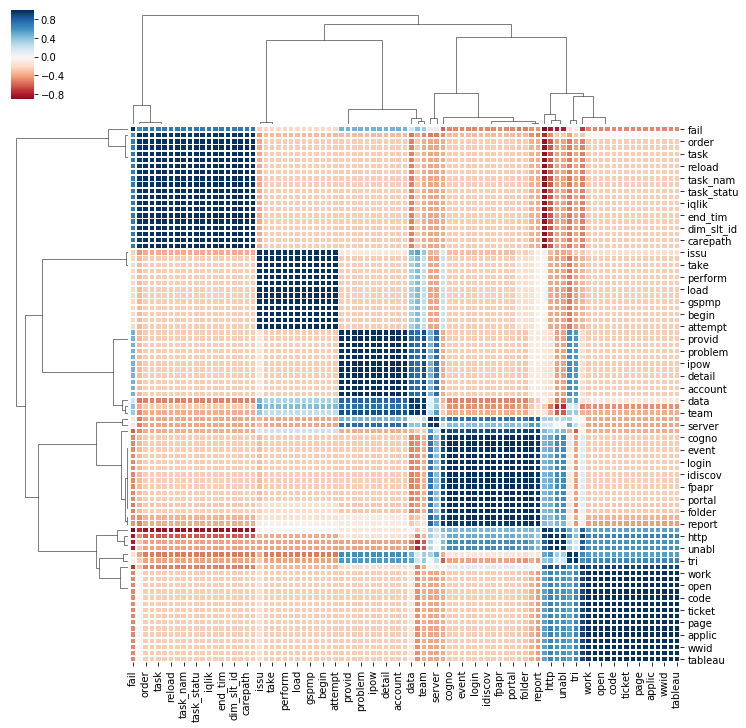

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [48]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [49]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)
    return X_train, X_test, y_train, y_test

In [50]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [51]:
from sklearn.externals import joblib

In [52]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Resolution Category of the ticket

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          3361536   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 5,409,799
Trainable params: 5,409,799
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 135

['model-simple_sol.pkl']

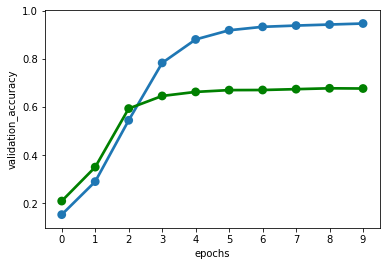

In [53]:
X_train, X_test, y_train, y_test = data_set_split(y_sol)

model_file = 'weights-simple_sol.hdf5'
model = model_training(num_class_sol, model_file)
joblib.dump(model,'model-simple_sol.pkl')

In [54]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6523560209424084

In [55]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [57]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Resolution_category.values)
text_labels = encoder.classes_ 


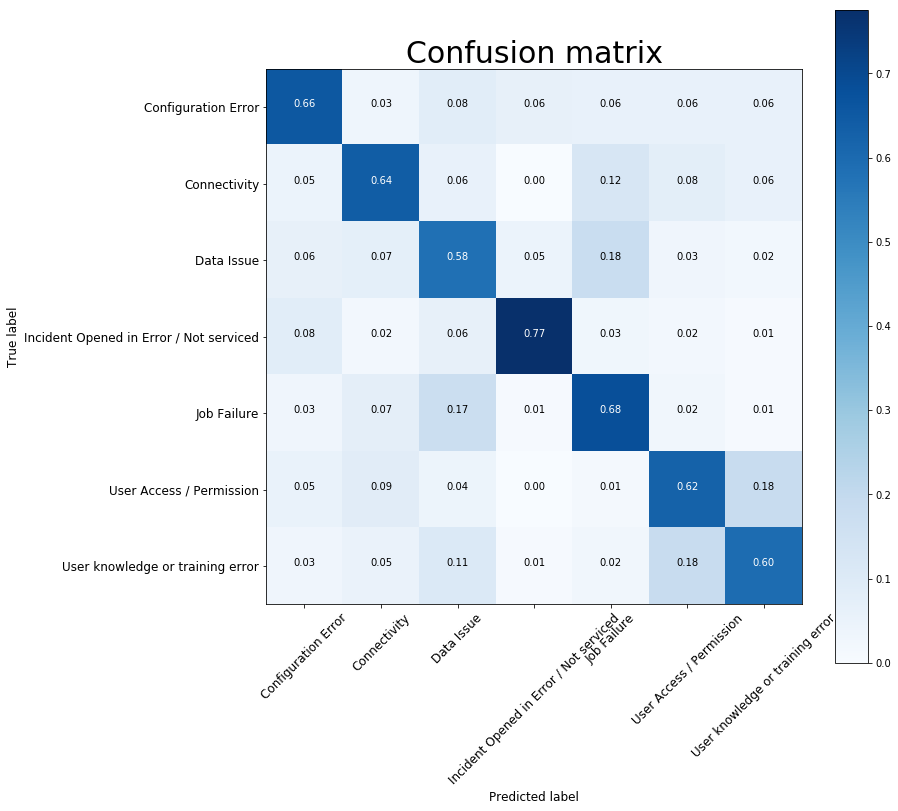

In [58]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [59]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    #LSTM(64)(embedding_layer)
    x = LSTM(100, dropout=0.2, recurrent_dropout=0.5)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=100, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=30, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Resolution Category using LSTM RNN

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          3361536   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 3,456,599
Trainable params: 3,456,599
Non-trainable params: 0
_________________________________________________________________
Train on 13595 samples, validate on 4532 samples
Epoch 1/30
13595/13595 [==============================] - 73s 5ms/step - loss: 1.62

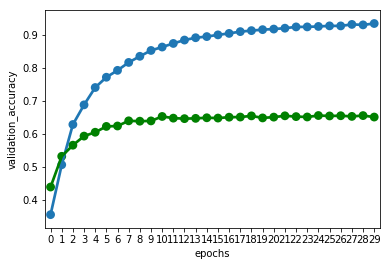

In [60]:
X_train, X_test, y_train, y_test = data_set_split(y_sol)
model_lstm = lstm_model_training(num_class_sol,"weights_sol.hdf5")
joblib.dump(model_lstm,'model_sol.pkl')
predicted = model_lstm.predict(X_test)

In [73]:
#After adding drop out to reduce overfitting and increasin batch
predicted = model_lstm.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6376963350785341

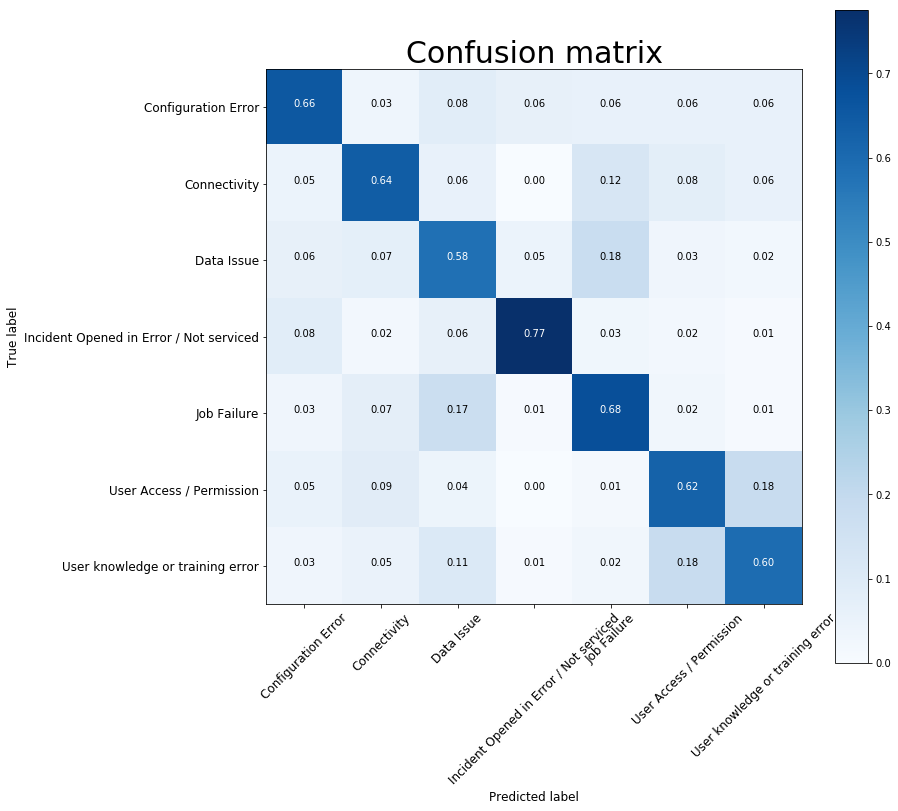

In [71]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       145
           1       0.67      0.64      0.66       145
           2       0.52      0.58      0.55       127
           3       0.87      0.77      0.82       142
           4       0.59      0.68      0.63       123
           5       0.65      0.62      0.64       152
           6       0.60      0.60      0.60       121

   micro avg       0.65      0.65      0.65       955
   macro avg       0.65      0.65      0.65       955
weighted avg       0.66      0.65      0.65       955

